In [1]:
import glob
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
import numpy as np

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

### Создаём аугментатор

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

### Выбираем размер изображений

In [ ]:
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

### Загружаем набор данных

In [ ]:
age_labels = []
gender_labels = []
images = []

for image_name in glob.glob('./UTKFace/*.jpg'):
    items = image_name.rsplit('/',1)[1].split('_')
    
    age = int(items[0])
    gender = int(items[1])
    
    age_labels.append(age)
    gender_labels.append(gender)
    
    image = cv2.imread(image_name)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image,(img_rows, img_cols), interpolation = cv2.INTER_CUBIC)    
    gray_image = gray_image.reshape((img_rows, img_cols, 1))
    
    images.append(gray_image)

age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
images = np.array(images)

In [ ]:
images = images / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, gender_labels, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(images, age_labels, test_size=0.3, random_state=42)

In [ ]:
num_classes = np.unique(gender_labels).shape[0]

In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Создаём модель

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(1, kernel_initializer='normal'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# model.compile(loss='mean_squared_error',
#               optimizer='rmsprop',
#               metrics=['mse', 'mae', 'mape'])

### Обучаем модель

In [ ]:
datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 100

In [ ]:
history_callback =  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                        epochs=epochs,
                                        validation_data=(X_test, y_test),
                                        workers=4)

Epoch 1/100
519/519 [==============================] - 21s 41ms/step - loss: 0.6572 - acc: 0.6299 - val_loss: 0.5791 - val_acc: 0.7074
Epoch 2/100
519/519 [==============================] - 20s 38ms/step - loss: 0.6102 - acc: 0.6704 - val_loss: 0.5215 - val_acc: 0.7377
Epoch 3/100
519/519 [==============================] - 20s 38ms/step - loss: 0.5750 - acc: 0.7076 - val_loss: 0.4728 - val_acc: 0.7819
Epoch 4/100
519/519 [==============================] - 20s 38ms/step - loss: 0.5377 - acc: 0.7311 - val_loss: 0.4295 - val_acc: 0.8015
Epoch 5/100
519/519 [==============================] - 20s 38ms/step - loss: 0.5038 - acc: 0.7550 - val_loss: 0.3803 - val_acc: 0.8275
Epoch 6/100
519/519 [==============================] - 20s 38ms/step - loss: 0.4818 - acc: 0.7712 - val_loss: 0.3643 - val_acc: 0.8414
Epoch 7/100
519/519 [==============================] - 20s 38ms/step - loss: 0.4572 - acc: 0.7894 - val_loss: 0.3644 - val_acc: 0.8482
Epoch 8/100
519/519 [==============================] - 

In [ ]:
loss_history = history_callback.history["loss"]

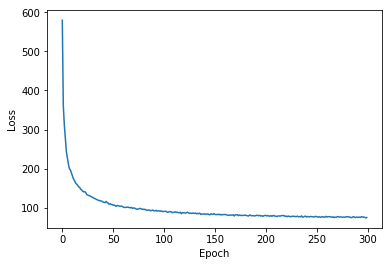

In [ ]:
plt.plot(loss_history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Смотрим на предсказания

[0.15493163 0.84506834]
[0. 1.]


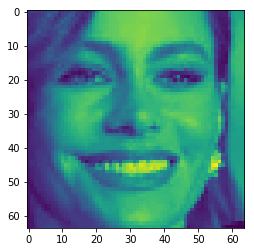

In [ ]:
img_idx = 1000
p_age = model.predict(np.array([X_test[img_idx]]))
print(p_age[0])
print(y_test[img_idx])
plt.imshow(X_test[img_idx].reshape(img_cols, img_rows))
plt.show()

### Сохраняем модель

In [ ]:
model_json = model.to_json()
with open("gender_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gender_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json

In [ ]:
keras.__version__

'2.2.0'

### Загружаем модель

In [ ]:
# load json and create model
json_file = open('gender_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
# load weights into new model
loaded_model.load_weights("gender_model.h5")
print("Loaded model from disk")

Loaded model from disk


[0.6514349 0.3485651]
[1. 0.]


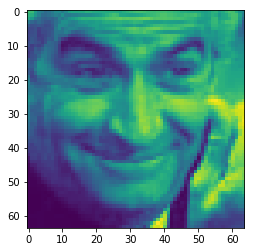

In [ ]:
img_idx = 1090
p_age = loaded_model.predict(np.array([X_test[img_idx]]))
print(p_age[0])
print(y_test[img_idx])
plt.imshow(X_test[img_idx].reshape(img_cols, img_rows))
plt.show()